In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from openpyxl import load_workbook
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})

# Loading the data


In [2]:
with open("../OneDrive_1_05-10-2018/Headers.csv", 'rt') as f:
    headers = pd.read_csv(f)

In [3]:
data = dict()
for file in range(2013,2019):
    print(file)
    with open("../OneDrive_1_05-10-2018/%s.csv"%file, 'rt') as f:
        data[file] = pd.read_csv(f,header=None)
        data[file].columns = headers.columns
        data[file]["year"] = file

2013
2014
2015
2016
2017
2018


In [40]:
all_data = pd.concat([item for _,item in data.items()])


In [41]:
for col in ['userid','company','company_de']:
    all_data[col] = pd.to_numeric(all_data[col],downcast='unsigned')

/Users/severinhatt/Virtualenvs/thinkful/base_plotting/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [6]:
wb = load_workbook(filename='../OneDrive_1_05-10-2018/SRM Trades.xlsx', read_only=True)
ws = wb.active
srm = list()
for row in ws.rows:
    srm_list = {'id': row[0].value ,'trade': row[1].value , 'active': row[2].value}
    srm.append(srm_list)
srm_df = pd.DataFrame.from_records(srm[1:]) #first line is the header

In [42]:
all_data=all_data.merge(srm_df,left_on='trade',right_on="id").drop("trade_x",axis=1).rename({"trade_y":"trade","id":"trade_id"},axis=1)

In [ ]:
all_data[all_data.year == 2013].sample(5)

In [43]:
#In 2013 SwipeIn seems to only by a time with no dates...
all_data_but_2013 =  all_data[all_data.year != 2013].copy()

In [47]:
for col in ['swipeIn','swipeOut']:
    all_data_but_2013[col] = pd.to_datetime(all_data_but_2013[col])
all_data_but_2013["work_hours"] = (all_data_but_2013.swipeOut - all_data_but_2013.swipeIn).dt.seconds/3600
all_data_but_2013["session_minute"] = (all_data_but_2013.swipeOut - all_data_but_2013.swipeIn).dt.seconds/60

In [48]:
all_data_but_2013["work_hours"] = (all_data_but_2013.swipeOut - all_data_but_2013.swipeIn).dt.seconds/3600
all_data_but_2013["session_minute"] = (all_data_but_2013.swipeOut - all_data_but_2013.swipeIn).dt.seconds/60


all_data_but_2013.info()

In [12]:
all_data_but_2013.describe()

,userid,auto,company,company_de,panel_in,panel_out,AreaID,SiteID,year,active,id,work_hours,session_minute
count,1.677834e+07,1.677834e+07,1.677834e+07,1.677834e+07,1.677834e+07,1.677834e+07,1.677834e+07,1.677834e+07,1.677834e+07,16778344.0,1.677834e+07,1.674558e+07,1.674558e+07
mean,6.015447e+04,9.699348e-02,9.220415e+02,9.174021e+02,2.152038e+02,1.924310e+02,5.554201e+01,3.607639e+01,2.015781e+03,1.0,1.530737e+03,1.493867e+00,8.963204e+01
std,3.177530e+04,2.959489e-01,9.646966e+02,9.844251e+02,1.377042e+02,1.447427e+02,3.556699e+01,2.156686e+01,1.138198e+00,0.0,4.776844e+02,2.364724e+00,1.418834e+02
min,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.014000e+03,1.0,1.130000e+03,0.000000e+00,0.000000e+00
25%,3.447400e+04,0.000000e+00,1.510000e+02,1.240000e+02,7.400000e+01,7.100000e+01,1.800000e+01,1.500000e+01,2.015000e+03,1.0,1.229000e+03,9.416667e-02,5.650000e+00
50%,6.098700e+04,0.000000e+00,6.700000e+02,6.490000e+02,2.100000e+02,1.790000e+02,5.300000e+01,3.700000e+01,2.016000e+03,1.0,1.310000e+03,5.761111e-01,3.456667e+01
75%,8.250200e+04,0.000000e+00,1.354000e+03,1.354000e+03,3.230000e+02,3.020000e+02,7.400000e+01,4.200000e+01,2.017000e+03,1.0,1.657000e+03,1.930278e+00,1.158167e+02
max,1.306770e+05,1.000000e+00,4.242000e+03,4.242000e+03,5.350000e+02,5.360000e+02,1.420000e+02,9.600000e+01,2.018000e+03,1.0,3.577000e+03,2.399861e+01,1.439917e+03


In [49]:
all_data_but_2013["swipeIn_date"] =all_data_but_2013.swipeIn.dt.date
all_data_but_2013["swipeIn_date"] = pd.to_datetime(all_data_but_2013["swipeIn_date"])

In [14]:
swipe_per_day_per_user = all_data_but_2013[~all_data_but_2013.work_hours.isna()].groupby(["trade","userid","swipeIn_date"]).agg({'userid': 'count', 'work_hours': ['sum','max',"median",'min']})

In [15]:
swipe_per_day_per_user.columns = swipe_per_day_per_user.columns.droplevel()

In [16]:
swipe_per_day_per_user.head()

count       sum       max  \
trade                  userid  swipeIn_date                              
360 EXCAVATOR OPERATOR 46876.0 2017-01-27       16  5.299722  1.045278   
                               2017-01-30        7  7.109722  2.396389   
                               2017-01-31        8  3.615278  1.313056   
                               2017-02-01       14  6.902222  2.419167   
                               2017-02-02       19  6.678333  1.560000   

                                               median       min  
trade                  userid  swipeIn_date                      
360 EXCAVATOR OPERATOR 46876.0 2017-01-27    0.051250  0.008611  
                               2017-01-30    0.799167  0.058611  
                               2017-01-31    0.039306  0.000000  
                               2017-02-01    0.027083  0.008889  
                               2017-02-02    0.013889  0.008611

In [17]:
people_per_day=swipe_per_day_per_user.reset_index().groupby(["swipeIn_date"])\
.agg({'userid': 'count', 'sum': 'sum','max':'max',"median":"median",'min':'min'})\
.rename(columns={'userid':'user_count',"sum":"sum_hours"})\
.reset_index()

In [18]:
people_per_day["weekday"]= people_per_day.swipeIn_date.dt.weekday

In [19]:
people_per_day[people_per_day.user_count==np.max(people_per_day.user_count)]

,swipeIn_date,user_count,sum_hours,max,median,min,weekday
900,2016-06-21,4406,31718.271111,23.188333,0.821944,0.0,1


In [20]:
all_data_but_2013[all_data_but_2013.swipeIn_date=='2016-06-21']

,userid,swipeIn,swipeOut,auto,company,company_de,panel_in,panel_out,AreaID,SiteID,year,active,id,trade,work_hours,session_minute,swipeIn_date
268634,26365.0,2016-06-21 00:02:48,2016-06-21 00:37:27,0,1956.0,1956.0,321,324,47,34,2016,1,1285,SECURITY,0.577500,34.650000,2016-06-21
268635,28488.0,2016-06-21 00:05:20,2016-06-21 00:18:42,0,835.0,835.0,184,185,53,37,2016,1,1285,SECURITY,0.222778,13.366667,2016-06-21
268636,67008.0,2016-06-21 00:12:02,2016-06-21 01:50:14,0,835.0,835.0,184,185,53,37,2016,1,1285,SECURITY,1.636667,98.200000,2016-06-21
268637,24056.0,2016-06-21 00:16:42,2016-06-21 00:16:42,1,10.0,10.0,15,0,5,3,2016,1,1285,SECURITY,0.000000,0.000000,2016-06-21
268638,26715.0,2016-06-21 00:17:41,2016-06-21 00:18:43,0,835.0,835.0,184,173,53,37,2016,1,1285,SECURITY,0.017222,1.033333,2016-06-21
268639,26715.0,2016-06-21 00:19:29,2016-06-21 00:36:11,0,835.0,835.0,184,185,53,37,2016,1,1285,SECURITY,0.278333,16.700000,2016-06-21
268640,28488.0,2016-06-21 00:37:07,2016-06-21 02:43:33,0,835.0,835.0,184,185,53,37,2016,1,1285,SECURITY,2.107222,126.433333,2016-06-21
268641,24056.0,2016-06-21 00:43:58,2016-06-21 00:44:01,0,10.0,10.0,15,16,5,3,2016,1,1285,SECURITY,0.000833,0.050000,2016-06-21
268642,24056.0,2016-06-21 00:45:01,2016-06-21 05:31:36,0,10.0,10.0,15,16,5,3,2016,1,1285,SECURITY,4.776389,286.583333,2016-06-21
268643,66646.0,2016-06-21 01:04:20,2016-06-21 01:05:04,0,835.0,835.0,199,234,53,37,2016,1,1285,SECURITY,0.012222,0.733333,2016-06-21


In [21]:
people_per_day["year"] = people_per_day.swipeIn_date.dt.year

In [22]:
swipe_per_day_per_user_df = swipe_per_day_per_user.reset_index()
swipe_per_day_per_user_df["year"] = swipe_per_day_per_user_df.swipeIn_date.dt.year

[]

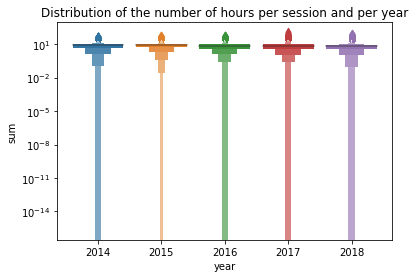

In [23]:
g =sns.boxenplot(data=swipe_per_day_per_user_df,x="year",y="sum")
g.set_title("Distribution of the number of hours per session and per year");

g.semilogy()

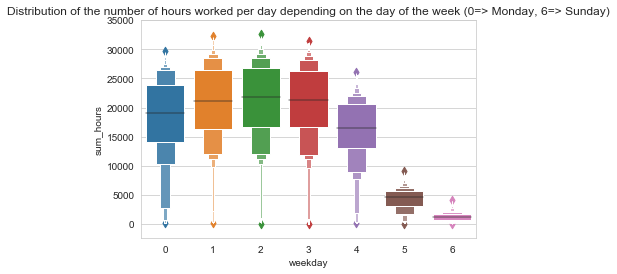

In [24]:
sns.set_style("whitegrid")
sns.boxenplot(data=people_per_day,x="weekday",y="sum_hours")\
.set_title("Distribution of the number of hours worked per day depending on the day of the week (0=> Monday, 6=> Sunday)");


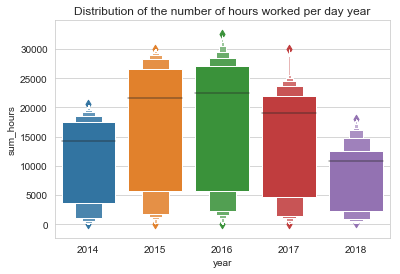

In [25]:
sns.set_style("whitegrid")
sns.boxenplot(data=people_per_day,x="year",y="sum_hours")\
.set_title("Distribution of the number of hours worked per day year");


[]

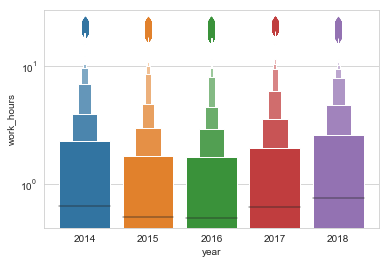

In [26]:
sns.set_style("whitegrid")
g = sns.boxenplot(data=all_data_but_2013,x="year",y="work_hours")
g.semilogy()

[]

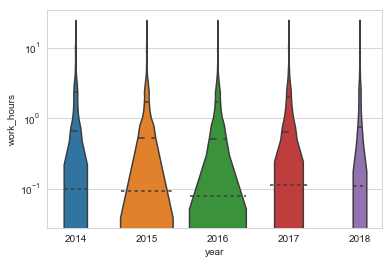

In [27]:
sns.set_style("whitegrid")
g = sns.violinplot(data=all_data_but_2013,x="year",y="work_hours",scale = 'count',inner = 'quartile')
g.semilogy()

[]

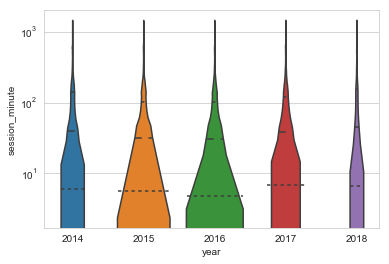

In [28]:
sns.set_style("whitegrid")
g = sns.violinplot(data=all_data_but_2013,x="year",y="session_minute",scale = 'count',inner = 'quartile')
g.semilogy()

In [29]:
trade_per_day=swipe_per_day_per_user.reset_index().groupby(["trade","swipeIn_date"])\
.agg({'trade': 'count', 'sum': 'sum','max':'max',"median":"median",'min':'min'})\
.rename(columns={'trade':'trade_count',"sum":"sum_hours"})\
.reset_index()

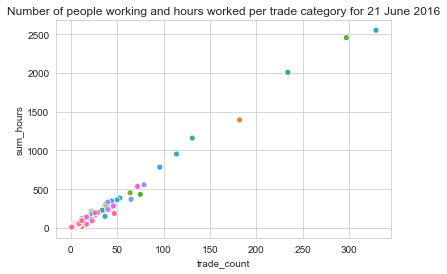

In [30]:
#We can graphically confirm that people indeed work a little more than 8 hours per day!
sns.scatterplot(data=trade_per_day[trade_per_day.swipeIn_date=='2016-06-21'],
                x="trade_count",y="sum_hours",hue="trade",
               legend=False)\
.set_title("Number of people working and hours worked per trade category for 21 June 2016");

In [31]:
all_data_but_2013["swipe_in_out_same_day"] = all_data_but_2013.swipeIn.dt.date == all_data_but_2013.swipeOut.dt.date

In [32]:
#Only a very small portion of the swipes have different date for swipe in and out.
sum(all_data_but_2013["swipe_in_out_same_day"])/all_data_but_2013.shape[0]

0.9926886705863225

In [38]:
trade_per_day[trade_per_day.trade.str.contains("DRIVER")].trade.unique()

array(['360 MACHINE DRIVER', 'BALLAST DRIVER', 'BOBCAT DRIVER',
       'CHERRY PICKER DRIVER', 'COMPACT CRANE DRIVER', 'CRANE DRIVER',
       'CRANE OPERATOR DRIVER', 'CRAWLER CRANE DRIVER', 'DELIVERY DRIVER',
       'DIAMOND  DRIVER', 'DIGGER DRIVER', 'DRIVER', 'DRIVER    LABOURER',
       'DRIVER OPERATOR', 'DUMPER DRIVER', 'EXCAVATOR DRIVER',
       'FABRICATOR DRIVER', 'FIXER MOBILE CRAINE DRIVER',
       'FORK LIFT DRIVER', 'FORKLIFT DRIVER', 'HEIV BALLAST DRIVER',
       'HGV DRIVER', 'HIAB DRIVER',
       'HOIST AND DUMPER AND FORKLIFT DRIVER', 'HOIST DRIVER',
       'JCB DRIVER', 'LABOURER DRIVER', 'LASER DRIVER', 'LIFT DRIVER',
       'LORRY DRIVER', 'MACHINE DRIVER', 'MECHINE DRIVER', 'PLANT DRIVER',
       'RIG DRIVER', 'ROLLER  DRIVER', 'SCAFOLDER DRIVER',
       'TELEHANDLER DRIVER', 'TOWER CRANE DRIVER'], dtype=object)

In [89]:
all_date_2013_truck_driver = all_data_but_2013[(all_date_2013_truck_driver.auto!=1) & all_data_but_2013.trade_id.isin([1337, 1187, 1220, 1825, 1846, 2529, 3015])]

In [90]:
all_date_2013_truck_driver.head()

,userid,swipeIn,swipeOut,auto,company,company_de,panel_in,panel_out,AreaID,SiteID,year,active,trade_id,trade,work_hours,session_minute,swipeIn_date
6180793,5919.0,2014-01-06 06:50:41,2014-01-06 16:48:10,0,53.0,53.0,27,28,9,6,2014,1,1187,DRIVER,9.958056,597.483333,2014-01-06
6180794,6717.0,2014-01-06 07:04:34,2014-01-06 08:10:16,0,268.0,268.0,60,62,15,12,2014,1,1187,DRIVER,1.095000,65.700000,2014-01-06
6180795,4487.0,2014-01-06 07:24:10,2014-01-06 17:28:54,0,211.0,91.0,82,83,21,16,2014,1,1187,DRIVER,10.078889,604.733333,2014-01-06
6180796,7816.0,2014-01-06 07:25:03,2014-01-06 11:02:39,0,312.0,312.0,76,77,19,14,2014,1,1187,DRIVER,3.626667,217.600000,2014-01-06
6180798,4487.0,2014-01-06 07:39:16,2014-01-06 07:55:10,0,211.0,91.0,78,79,20,16,2014,1,1187,DRIVER,0.265000,15.900000,2014-01-06


In [91]:
group_by_site_user = all_date_2013_truck_driver.groupby(["swipeIn_date","SiteID","userid"])\
.agg({'userid': 'count', 'session_minute': ['sum','max',"median",'min','std']})

In [92]:
group_by_site_user.columns = group_by_site_user.columns.droplevel()

In [93]:
group_by_site_user=group_by_site_user.reset_index()

In [94]:
group_by_site_user.columns

Index(['swipeIn_date', 'SiteID', 'userid', 'count', 'sum', 'max', 'median',
       'min', 'std'],
      dtype='object')

In [95]:
group_by_site_user.columns = ['swipeIn_date', 'SiteID', 'userid', 'nb_time', 'presence_site', 'max_presence', 'median_presence',
       'min_presence', 'std_presence']

In [112]:
all_date_2013_truck_driver.SiteID.unique()

array([ 6, 12, 16, 14,  4,  9, 23, 24, 25, 34,  5, 15, 18, 43, 45, 37, 51,
       49, 46, 42, 57, 76, 66, 35, 96, 74, 41, 58])

/Users/severinhatt/Virtualenvs/thinkful/base_plotting/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1500)

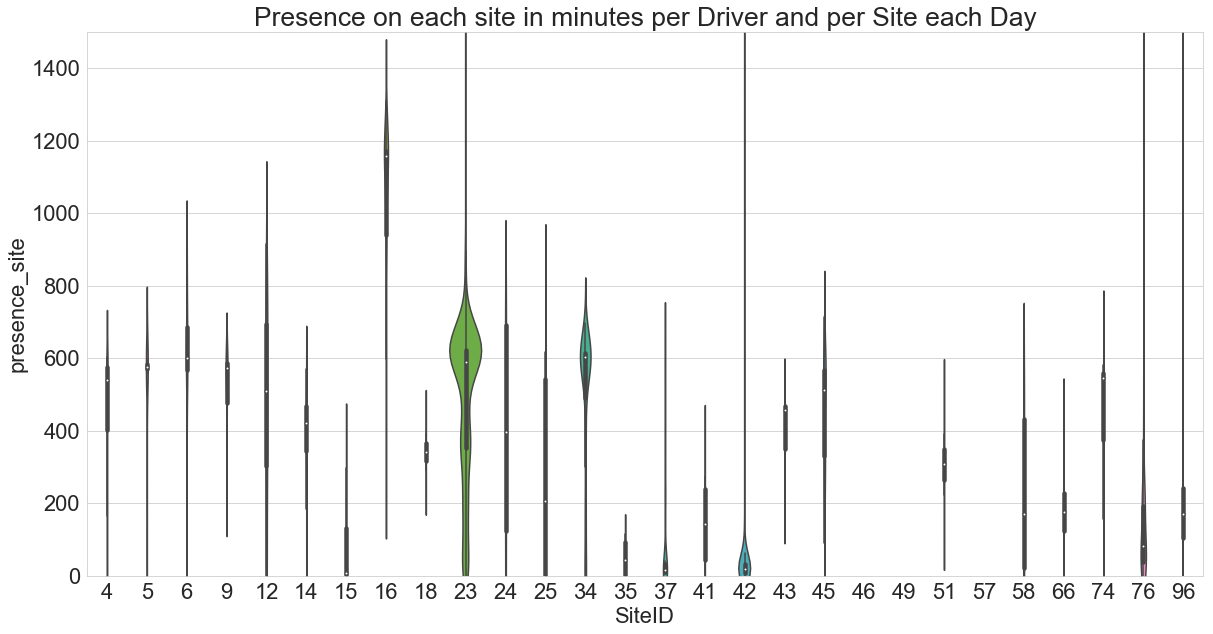

In [97]:
sns.set_style("whitegrid")
g=sns.violinplot(data=group_by_site_user,x="SiteID",y="presence_site",scale = 'count')
g.set_title("Presence on each site in minutes per Driver and per Site each Day")

plt.ylim([0,1500])

(0, 1500)

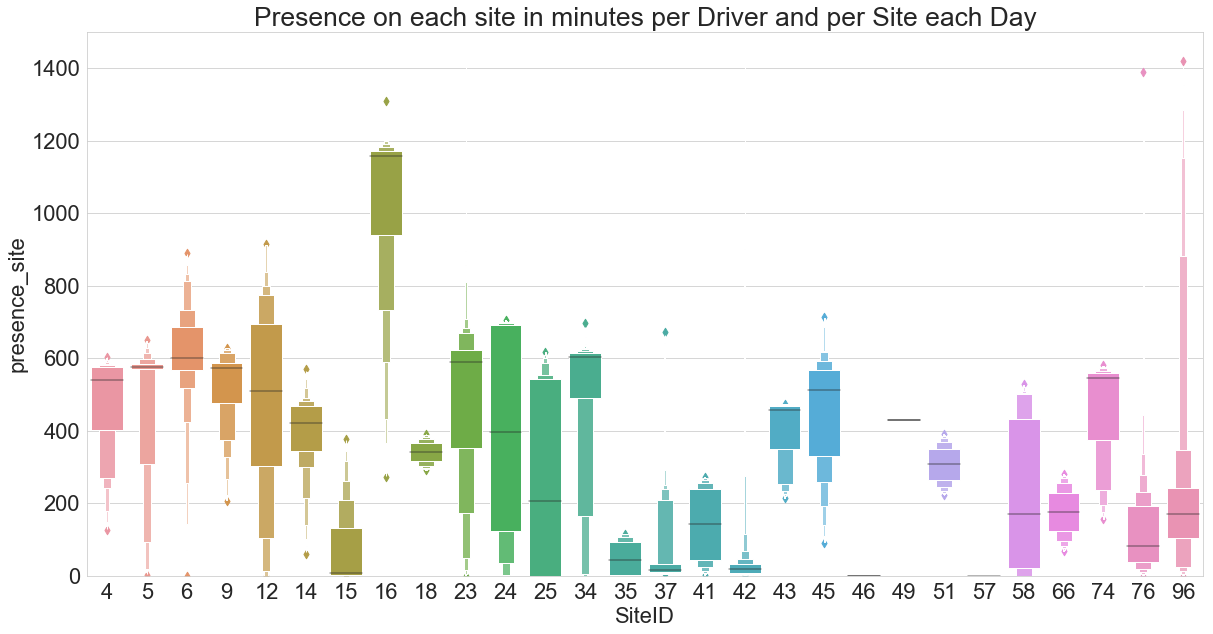

In [98]:
sns.set_style("whitegrid")
g=sns.boxenplot(data=group_by_site_user,x="SiteID",y="presence_site")
g.set_title("Presence on each site in minutes per Driver and per Site each Day")

plt.ylim([0,1500])

/Users/severinhatt/Virtualenvs/thinkful/base_plotting/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 15)

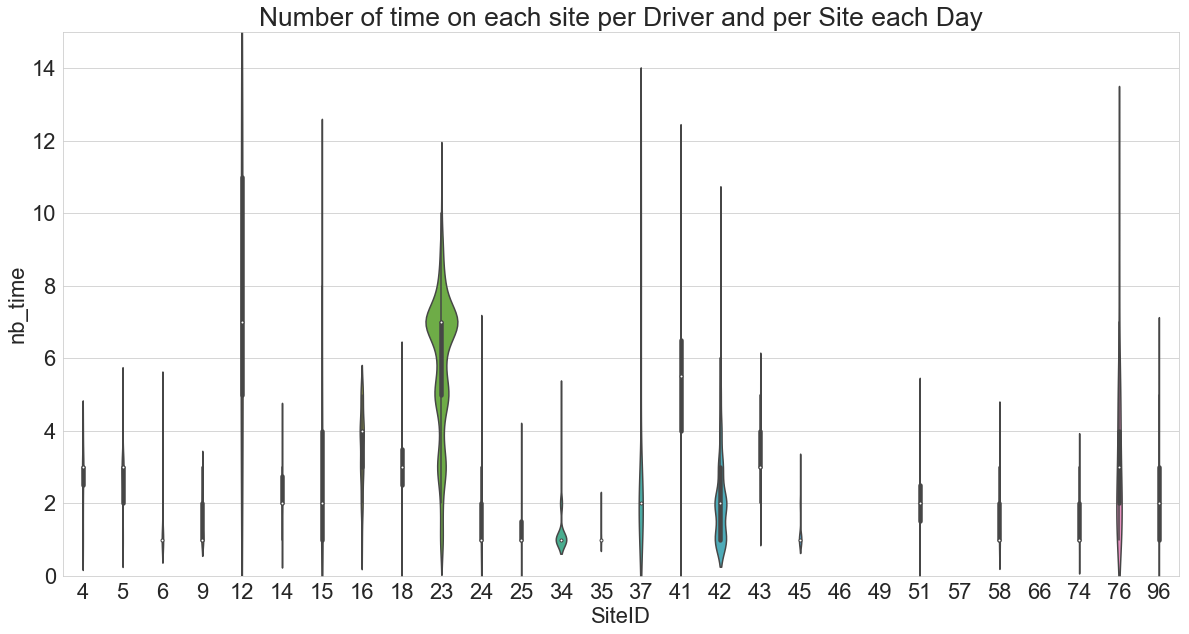

In [100]:
sns.set_style("whitegrid")
g=sns.violinplot(data=group_by_site_user,x="SiteID",y="nb_time",scale = 'count')
g.set_title("Number of time on each site per Driver and per Site each Day")
plt.ylim([0,15])

In [101]:
driver_on_each_site_per_day = all_date_2013_truck_driver.groupby(["swipeIn_date","SiteID"])\
.agg({'SiteID': 'count', 'session_minute': ['sum','max',"median",'min','std']})

In [102]:
driver_on_each_site_per_day.head()

SiteID session_minute                                      \
                     count            sum         max      median         min   
swipeIn_date SiteID                                                             
2014-01-06   4           4     428.483333  192.200000  105.233333   25.816667   
             6           1     597.483333  597.483333  597.483333  597.483333   
             12          7     651.316667  161.966667   77.883333    8.733333   
             14          2     422.683333  217.600000  211.341667  205.083333   
             16          5    1156.366667  604.733333  189.283333   15.900000   

                                 
                            std  
swipeIn_date SiteID              
2014-01-06   4        68.101786  
             6              NaN  
             12       55.639681  
             14        8.850620  
             16      223.410767

In [87]:
all_date_2013_truck_driver[(all_date_2013_truck_driver.SiteID==4) & (all_date_2013_truck_driver.swipeIn_date=='2014-01-06')]

,userid,swipeIn,swipeOut,auto,company,company_de,panel_in,panel_out,AreaID,SiteID,year,active,trade_id,trade,work_hours,session_minute,swipeIn_date
6180797,2969.0,2014-01-06 07:29:09,2014-01-06 07:29:09,1,128.0,2.0,17,0,7,4,2014,1,1187,DRIVER,0.000000,0.000000,2014-01-06
6180801,2969.0,2014-01-06 08:47:35,2014-01-06 08:47:35,1,128.0,2.0,17,0,7,4,2014,1,1187,DRIVER,0.000000,0.000000,2014-01-06
6180802,2969.0,2014-01-06 09:15:27,2014-01-06 10:55:19,0,128.0,2.0,17,18,7,4,2014,1,1187,DRIVER,1.664444,99.866667,2014-01-06
6180806,2969.0,2014-01-06 11:40:46,2014-01-06 14:52:58,0,128.0,2.0,17,18,7,4,2014,1,1187,DRIVER,3.203333,192.200000,2014-01-06
6180811,2969.0,2014-01-06 15:34:20,2014-01-06 16:00:09,0,128.0,2.0,17,18,7,4,2014,1,1187,DRIVER,0.430278,25.816667,2014-01-06
6180812,2969.0,2014-01-06 16:02:27,2014-01-06 17:53:03,0,128.0,2.0,17,18,7,4,2014,1,1187,DRIVER,1.843333,110.600000,2014-01-06


In [104]:
driver_on_each_site_per_day.columns = driver_on_each_site_per_day.columns.droplevel()

In [108]:
driver_on_each_site_per_day = driver_on_each_site_per_day.reset_index()

Text(0.5,1,'Number of driver sessions on each site each Day')

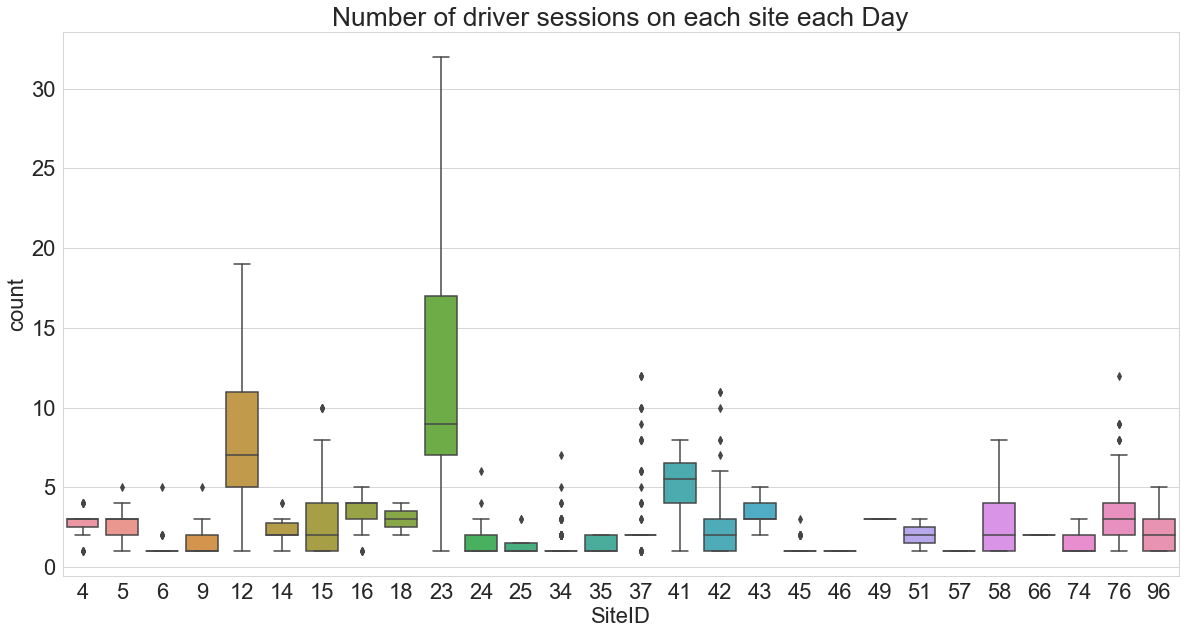

In [111]:
sns.set_style("whitegrid")
g=sns.boxplot(data=driver_on_each_site_per_day,x="SiteID",y="count")
g.set_title("Number of driver sessions on each site each Day")